#Data Wrangling NLP Code for Word Clouds and ML models code


Please import all of these packages and dependencies to ensure that the code runs.

If you get errors please use !pip install in your notebook to install the packages and their dependencies if not already downloaded and import them.

I am using a google-colab environment for this code so you will be needing the original tiktok and youtube dataset file uploaded into your own colab to import and configure your paths. This original dataset is the file called "youtube_shorts_tiktok_trends_2025.csv"

Then you will need to make sure to run all the imports and code cells in the correct order.

It is imperative that the code is run in order and each cell is executed after the one before is done running.

In [1]:
# Imports and Setup

import os
import re
from collections import Counter

# classic datascience packages
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# nlp packages
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("punkt_tab")

# NLTK setup
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/MyDrive/DataWrangling/youtube_shorts_tiktok_trends_2025.csv'


Mounted at /content/drive


In [3]:
# Paths setting and configs to save plots

CSV_PATH = "/content/drive/MyDrive/DataWrangling/youtube_shorts_tiktok_trends_2025.csv"

TEXT_COLS = ["title", "category", "tags", "hashtag"]

LABEL_COL = "viral"
COMPLETION_COL = "completion_rate"

# our exploratory completion-rate bins based on Ryan's significance testing
BINS = [(0.44, 0.45), (0.72, 0.73)]

OUT_DIR = "simple_wordclouds"
os.makedirs(OUT_DIR, exist_ok=True)

# load data
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)


Loaded: (48079, 58)


In [4]:
df

,platform,country,region,language,category,hashtag,title_keywords,author_handle,sound_type,music_track,...,traffic_source,is_weekend,row_id,engagement_total,like_rate,dislike_rate,engagement_per_1k,engagement_like_rate,engagement_comment_rate,engagement_share_rate
0,TikTok,Jp,Asia,ja,Gaming,#Lifestyle,Night Routine — College,NextVision,trending,8bit loop,...,External,1,2e681528d17a1fe1986857942536ec27,30317,0.086159,0.004004,120.069,0.086159,0.012555,0.007830
1,TikTok,Se,Europe,sv,Food,#Sports,Morning Routine — College,DailyVlogsDiego,trending,Street vibe,...,Search,0,2e35fa0b2978b9cae635839c1d4e9e74,30577,0.085298,0.002421,113.005,0.085298,0.007850,0.007791
2,TikTok,Za,Africa,en,Art,#Workout,Night Routine — College,BeyondHub,licensed,Gallery pad,...,External,1,0d88a011235a82244995ef52961f9502,503,0.049154,0.001625,68.111,0.049154,0.004469,0.005146
3,TikTok,Kr,Asia,ko,News,#Esports,Best Settings for Fortnite,NextHub,original,Neutral piano,...,Search,1,e15cff7621ed3f9eb9d2c97c841be0f3,7828,0.086257,0.003164,108.156,0.086257,0.011205,0.005292
4,TikTok,Au,Oceania,en,Beauty,#Comedy,When your friend is Beginners,LucasOfficial,licensed,Soft glam loop,...,ForYou,1,d696b4f0a50ea70e7cb5021be7e198ec,1171,0.051441,0.001175,72.400,0.051441,0.004204,0.004142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48074,YouTube,Ke,Africa,sw,Lifestyle,#Motivation,Weekly Reset — Beginners,NoahChannel,licensed,Chill guitar,...,Search,0,a756bd218ad29bce51bad0fac806a857,2904,0.025804,0.001247,33.216,0.025804,0.003454,0.002059
48075,YouTube,Sa,Asia,ar,Art,#DanceChallenge,Weekly Reset — Beginners,MrYuki,trending,Gallery pad,...,Home,1,0aeb762f68a9867eaf0b937006933021,2461,0.040411,0.005011,49.725,0.040411,0.003213,0.003617
48076,YouTube,Kr,Asia,ko,Science,#Comedy,When your friend is 2025,LifeOfAyaka,original,Lab beeps,...,Suggested,1,78ebd3268e18a3033895739c44680d82,1415,0.033513,0.003593,43.827,0.033513,0.004027,0.004119
48077,YouTube,Br,South America,pt,Pets,#OOTD,GRWM: Beginners Edition,TechieNoah,trending,Cute whistle,...,Home,1,67fd2032ade8be89da4c0208fbc05596,2457,0.043857,0.003594,59.272,0.043857,0.006465,0.003088


In [5]:
# Add viral label based on virality threshold based on views.
# Views above 500,000 defined as viral for classification model and analysis purposes

In [6]:
cleaned_df = df.drop_duplicates().dropna()
print("After dropna:", cleaned_df.shape)

# Viral label based on views ≥ 500k
if "views" not in cleaned_df.columns:
    raise ValueError("Missing 'views' column for viral labeling.")

cleaned_df["viral"] = (cleaned_df["views"] >= 500_000).astype(int)

print("Viral counts:")
print(cleaned_df["viral"].value_counts())


After dropna: (48079, 58)
Viral counts:
viral
0    47241
1      838
Name: count, dtype: int64


In [7]:
# simple text cleaning using NLTK tool kit

# stopwords defined in a custom away also so repeated terms common on short form video contents and words like and do not come into word clouds.
STOP_WORDS = set(stopwords.words("english"))
STOP_WORDS.update([
    "tiktok","youtube","shorts","yt",
    "subscribe","sub","follow","like","share",
    "video","watch","channel","link","bio","click",
    "viral","trend","trending"
])

# Data cleaning for tiles and cats and such

# cleaning for link words and other messy data that commonly clutter video content

url_pat = re.compile(r"https?://\S+|www\.\S+")
mention_pat = re.compile(r"@[A-Za-z0-9_]+")

def clean_text(text):
    text = str(text).lower()
    text = url_pat.sub(" ", text)
    text = mention_pat.sub(" ", text)
    text = re.sub(r"[^a-z0-9\s#]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

def text_to_tokens(series):
    c = Counter()
    for s in series.fillna(""):
        cleaned = clean_text(s)
        tokens = word_tokenize(cleaned)
        tokens = [t for t in tokens if t not in STOP_WORDS and len(t) > 1]
        c.update(tokens)
    return c


def series_to_counter(series):
    c = Counter()
    for s in series.fillna(""):
        c.update(text_to_tokens(s))
    return c


In [8]:
# Data Splits into bins based on what Ryan defined - first significant jump and then most sig jump in bin analysis as denoted by stars

# We want to get text data from title, category, tags and hashtag for word clouds
TEXT_COLS = ["title", "category", "tags", "hashtag"]

# this is the column we are filtering by based on Ryan's significance testing
COMPLETION_COL = "completion_rate"

# bins that are significant and we want to explore deeper
BINS = [(0.44, 0.45), (0.72, 0.73)]

OUT_DIR = "simple_wordclouds"
os.makedirs(OUT_DIR, exist_ok=True)

# Viral / Non-viral
viral_df = cleaned_df[cleaned_df["viral"] == 1]
nonviral_df = cleaned_df[cleaned_df["viral"] == 0]

print("Viral:", len(viral_df), "Nonviral:", len(nonviral_df))

# Function for bin checking
def in_bins(x):
    try:
        x = float(x)
    except:
        return False
    return any(lo < x <= hi for lo, hi in BINS)

# Viral IN-bins vs OUT-of-bins
if COMPLETION_COL in cleaned_df.columns:
    viral_in = viral_df[viral_df[COMPLETION_COL].apply(in_bins)]
    viral_out = viral_df[~viral_df.index.isin(viral_in.index)]
    print("Viral IN-bins:", len(viral_in))
    print("Viral OUT-of-bins:", len(viral_out))
else:
    viral_in = None
    viral_out = None
    print("No completion_rate column found.")



Viral: 838 Nonviral: 47241
Viral IN-bins: 38
Viral OUT-of-bins: 800


In [9]:
# Create merged text field (title+category+tags+hashtag)

merge_cols = [c for c in ["title","category","tags","hashtag"] if c in cleaned_df.columns]
print("Merging:", merge_cols)

cleaned_df["merged_text"] = cleaned_df[merge_cols].fillna("").agg(" ".join, axis=1)

# viral / non-viral splits
viral_df    = cleaned_df[cleaned_df["viral"] == 1]
nonviral_df = cleaned_df[cleaned_df["viral"] == 0]

# bins
COMPLETION_COL = "completion_rate"
BINS = [(0.44, 0.45), (0.72, 0.73)]

def in_bins(x):
    try:
        x = float(x)
    except:
        return False
    return any(low < x <= high for low, high in BINS)

if COMPLETION_COL in cleaned_df.columns:
    viral_in  = viral_df[viral_df[COMPLETION_COL].apply(in_bins)]
    viral_out = viral_df[~viral_df.index.isin(viral_in.index)]
else:
    viral_in = None
    viral_out = None


Merging: ['title', 'category', 'tags', 'hashtag']


In [13]:
OUT_DIR = "simple_wordclouds"
os.makedirs(OUT_DIR, exist_ok=True)

def make_wc(counter, title, filename):
    if not counter:
        print(f"[SKIP] No words for {title}")
        return

    wc = WordCloud(width=1200, height=800, background_color="white")
    wc = wc.generate_from_frequencies(counter)

    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

    # save to your folder
    plt.savefig(os.path.join(OUT_DIR, filename), dpi=200, bbox_inches="tight")

    plt.close()

    # display in the notebook
    plt.show()

    print("Saved:", filename)



In [14]:
# Viral wordcloud
viral_wc = text_to_tokens(viral_df["merged_text"])
make_wc(viral_wc, "Viral Videos – Word Cloud", "viral_regular_wc.png")

# Non-viral wordcloud
nonviral_wc = text_to_tokens(nonviral_df["merged_text"])
make_wc(nonviral_wc, "Non-Viral Videos – Word Cloud", "nonviral_regular_wc.png")

# Viral IN-bins wordcloud
if viral_in is not None:
    in_wc = text_to_tokens(viral_in["merged_text"])
    make_wc(in_wc, "Viral IN-bins – Word Cloud", "viral_inbins_wc.png")

    out_wc = text_to_tokens(viral_out["merged_text"])
    make_wc(out_wc, "Viral OUT-of-bins – Word Cloud", "viral_outbins_wc.png")

Saved: viral_regular_wc.png
Saved: nonviral_regular_wc.png
Saved: viral_inbins_wc.png
Saved: viral_outbins_wc.png


In [15]:
# unique words in non viral

# build counters for viral + nonviral merged text
viral_counts = text_to_tokens(viral_df["merged_text"])
nonviral_counts = text_to_tokens(nonviral_df["merged_text"])

# words that appear in NON-VIRAL but never in VIRAL
unique_nonviral_words = {word: nonviral_counts[word]
                         for word in nonviral_counts
                         if word not in viral_counts}

print("Number of unique non-viral words:", len(unique_nonviral_words))

# top 50 by frequency
top50_nonviral = sorted(unique_nonviral_words.items(), key=lambda x: x[1], reverse=True)[:50]

print("\nTop 50 unique non-viral words:")
for word, freq in top50_nonviral:
    print(f"{word}: {freq}")


Number of unique non-viral words: 4

Top 50 unique non-viral words:
lamp: 66
shelf: 52
pvc: 25
cardboard: 24


In [16]:
# word cloud for unique words in non viral if there are


make_wc(
    unique_nonviral_words,
    "Unique Non-Viral Words",
    "unique_nonviral_wc.png"
)


Saved: unique_nonviral_wc.png


In [ ]:
# unique words in viral if there are

# build counters for viral + nonviral merged text
viral_counts = text_to_tokens(viral_df["merged_text"])
nonviral_counts = text_to_tokens(nonviral_df["merged_text"])

# words that appear in VIRAL but never in NON-VIRAL
unique_viral_words = {word: viral_counts[word]
                      for word in viral_counts
                      if word not in nonviral_counts}

print("Number of unique viral words:", len(unique_viral_words))

# top 50 by frequency
top50_viral = sorted(unique_viral_words.items(), key=lambda x: x[1], reverse=True)[:50]

print("\nTop 50 unique viral words:")
for word, freq in top50_viral:
    print(f"{word}: {freq}")


Number of unique viral words: 0

Top 50 unique viral words:


All of these word clouds are saved as pngs for ppt use, under simple_word clouds folder when you click on the lefthand side of google colab interface and instance based file icon.

# TF-IDF Smart Signal Counter Approach
We use TF-IDF to uncover combinations of words and phrases that will help us uncover more about virality.

In [ ]:
# TF-IDF and Logistic Regression Feature Importance
#tf id specific imports

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# X = text, y = viral label
X_text = cleaned_df["merged_text"].fillna("")
y = cleaned_df["viral"]

# TF-IDF Vectorizer (unigrams + bigrams)
vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),      # include unigrams + bigrams
    min_df=5                # ignore very rare words and this i can tune
)

X = vectorizer.fit_transform(X_text)

# Logistic Regression
model = LogisticRegression(max_iter=500)
model.fit(X, y)

# Get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

# Get coefficients for viral vs non-viral
coef = model.coef_[0]

# Top words associated with VIRAL videos or to push towards viral
top_viral_idx = np.argsort(coef)[-30:]      # top 30
top_viral_words = feature_names[top_viral_idx]
top_viral_scores = coef[top_viral_idx]

# Top words associated with NON-VIRAL videos or to push way from viral
top_nonviral_idx = np.argsort(coef)[:30]    # bottom 30
top_nonviral_words = feature_names[top_nonviral_idx]
top_nonviral_scores = coef[top_nonviral_idx]

# disp results
print("\nTop 30 VIRAL-associated words/phrases:")
for w, s in sorted(zip(top_viral_words, top_viral_scores), key=lambda x: x[1], reverse=True):
    print(f"{w}: {s:.4f}")

print("\nTop 30 NON-VIRAL-associated words/phrases:")
for w, s in sorted(zip(top_nonviral_words, top_nonviral_scores), key=lambda x: x[1]):
    print(f"{w}: {s:.4f}")





Top 30 VIRAL-associated words/phrases:
challenge dancechallenge: 1.4121
valorant fyp: 1.3574
fitness dogs: 1.3493
productivity study: 1.2152
notes tips: 1.2054
science song: 1.1298
music beat: 0.9986
friend budget: 0.9982
routine budget: 0.9942
evening: 0.9561
skincare makeup: 0.9523
diy fast: 0.9462
recipe fyp: 0.9452
minimal automotive: 0.9408
sports workout: 0.9322
did fitness: 0.9312
edition sports: 0.9292
fitness notes: 0.9034
sports football: 0.9001
fast kitchen: 0.8945
office education: 0.8928
sushi food: 0.8684
lifestyle routine: 0.8679
60s fashion: 0.8669
fitness: 0.8630
science challenge: 0.8507
esports fyp: 0.8489
ai ai: 0.8489
college honest: 0.8470
sample pets: 0.8398

Top 30 NON-VIRAL-associated words/phrases:
grwm fashion: -1.2110
beauty: -1.1475
tips study: -1.1071
recipe fast: -0.9737
sketch fyp: -0.9548
music dancechallenge: -0.9333
comedy relatable: -0.9246
kitchen fast: -0.9240
motivation lifestyle: -0.9113
news: -0.9002
song cover: -0.8875
challenge music: -0.8665

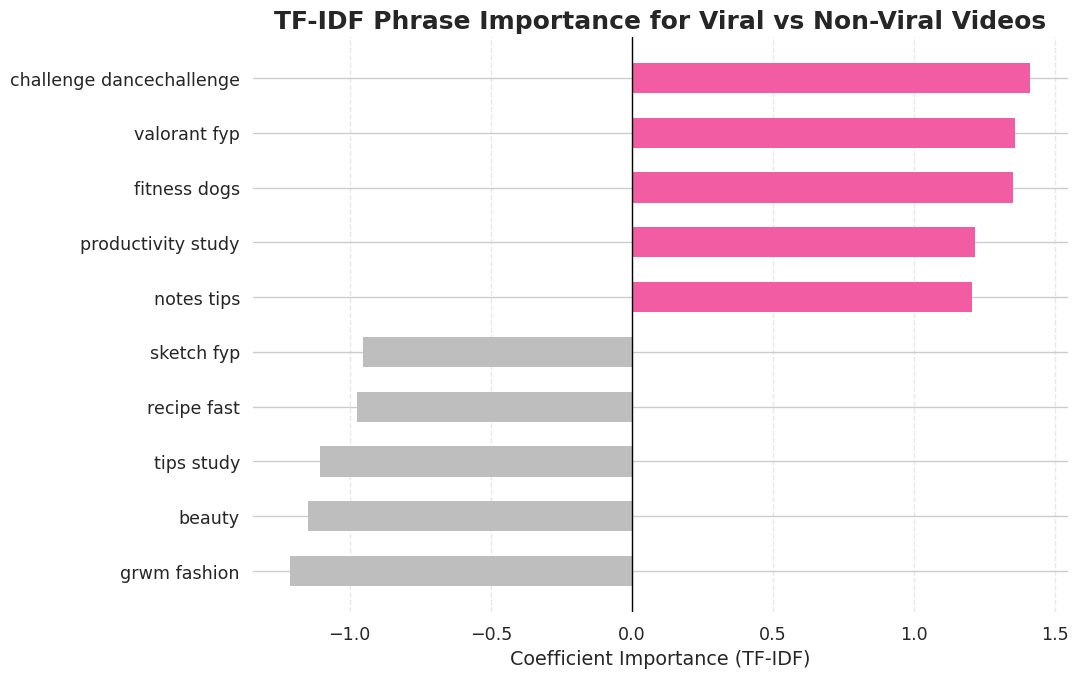

In [ ]:
# reimport ploting tools for debugging

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Top 5 viral + top 5 non-viral
viral_top5 = {
    "challenge dancechallenge": 1.4121,
    "valorant fyp": 1.3574,
    "fitness dogs": 1.3493,
    "productivity study": 1.2152,
    "notes tips": 1.2054
}

nonviral_top5 = {
    "grwm fashion": -1.2110,
    "beauty": -1.1475,
    "tips study": -1.1071,
    "recipe fast": -0.9737,
    "sketch fyp": -0.9548
}

# combined df
df = pd.DataFrame(
    list(viral_top5.items()) + list(nonviral_top5.items()),
    columns=["term", "coef"]
)

# category labeling
df["category"] = df["coef"].apply(lambda x: "Viral" if x > 0 else "Non-Viral")

# Sort
df = df.sort_values("coef")


sns.set_theme(style="whitegrid", font_scale=1.15)

# soft pink & soft gray
palette = {
    "Viral":    "#F25CA2",   # soft pink
    "Non-Viral": "#BEBEBE"   # soft gray
}

colors = df["category"].map(palette)

plt.figure(figsize=(11, 7))

# plot bars
plt.barh(
    df["term"],
    df["coef"],
    color=colors,
    edgecolor="none",
    height=0.55
)

# add vertical zero line
plt.axvline(0, color="black", linewidth=1)

# Title
plt.title(
    "TF-IDF Phrase Importance for Viral vs Non-Viral Videos",
    fontsize=18, weight="bold"
)
plt.xlabel("Coefficient Importance (TF-IDF)")

# Light, R-style grid to match team-mates r-rplot
sns.despine(left=True, bottom=True)
plt.grid(axis="x", linestyle="--", alpha=0.45)

plt.tight_layout()
plt.show()


In [ ]:
# Based on this custom TF-IF based approach, we think builiding an LDA topic model will help segment topics better and take more semantically similar words into account as well.
# Therefore, Estefano will be doing some topic modelling in depth later on to uncover some insights.

# Predictive Classification Modelling

In [51]:
# Import again to debug, chunk code

# important ml imports and data processing ones too

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import ways to do CV, encoding and such from sklearn for ML

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

# import models we want to test

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# import classification metrics
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
)

sns.set(style="whitegrid", font_scale=1.15)

# define e our filtered features gathered before video is posted
filtered_features = [
    "platform","country","region","language","category","hashtag","title_keywords",
    "sound_type","music_track","week_of_year","duration_sec","notes","device_type",
    "upload_hour","genre","trend_duration_days","trend_type","publish_dayofweek",
    "publish_period","event_season","tags","creator_avg_views","creator_tier",
    "season","publish_date_approx","year_month","title","title_length","has_emoji",
    "avg_watch_time_sec","device_brand","traffic_source",
    "is_weekend","row_id"
]


# Keep only filtered_features + target which is viral 0 or 1
keep_cols = [c for c in filtered_features if c in cleaned_df.columns] + ["viral"]
cleaned_df = cleaned_df[keep_cols].copy()
print("After feature filter:", cleaned_df.shape)

# 50/50 undersampling (non-viral down to same count as viral)
# played with diff props of undersampling but this resulted in the best improvements

df_viral = cleaned_df[cleaned_df["viral"] == 1]
df_nonviral = cleaned_df[cleaned_df["viral"] == 0]

# undersampling code
n_minority = len(df_viral)
df_nonviral_down = resample(
    df_nonviral,
    replace=False,
    n_samples=min(n_minority, len(df_nonviral)),
    random_state=42
)

# checking distribution for sanity

balanced_df = (
    pd.concat([df_viral, df_nonviral_down], axis=0)
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print(f"Balanced shape: {balanced_df.shape}")
print("Class balance after 50/50 undersampling:")
print(balanced_df["viral"].value_counts(normalize=True))


After feature filter: (48079, 35)
Balanced shape: (1676, 35)
Class balance after 50/50 undersampling:
viral
0    0.5
1    0.5
Name: proportion, dtype: float64


In [52]:
# From here on we use balanced_df
# The idea: undersampling makes the model see equal viral & non-viral,
# which usually improves recall and PR_AUC for the rare viral class.

# Feature split: numeric vs categorical

numeric_features = balanced_df.select_dtypes(include=np.number).columns.tolist()
numeric_features = [c for c in numeric_features if c != "viral"]  # exclude target

categorical_features = balanced_df.select_dtypes(exclude=np.number).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

X = balanced_df[numeric_features + categorical_features].copy()
y = balanced_df["viral"].astype(int).values

# We have a [reprocessor which scales numeric, one-hot encodes categorical data

num_tf = StandardScaler()

# over here I have add a precautionary section for a dense one hot encoder so everything downstream is easy
try:
    cat_tf = OneHotEncoder(
        handle_unknown="ignore",
        drop="if_binary",
        min_frequency=0.01,
        sparse_output=False
    )
except TypeError:
    cat_tf = OneHotEncoder(
        handle_unknown="ignore",
        drop="if_binary",
        sparse=False
    )

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_features),
        ("cat", cat_tf, categorical_features),
    ],
    remainder="drop"
)

# Models to compare - 3 defined based on our choices - log reg, rf and gb
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}

# Cross-validated metrics and were focus on F1, Recall, PR_AUC
# have a 5 fold CV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    print(f"Running CV for: {name}")
    pipe = Pipeline(steps=[("preprocess", preprocessor),
                           ("model", model)])

    # Get cross-validated probabilities for viral class
    proba = cross_val_predict(
        pipe, X, y, cv=cv,
        method="predict_proba",
        n_jobs=-1
    )[:, 1]

    preds = (proba >= 0.5).astype(int)

    metrics_dict = {
        "Model": name,
        "Accuracy": accuracy_score(y, preds),
        "F1": f1_score(y, preds, zero_division=0),
        "Precision": precision_score(y, preds, zero_division=0),
        "Recall": recall_score(y, preds, zero_division=0),
        "ROC_AUC": roc_auc_score(y, proba),
        "PR_AUC": average_precision_score(y, proba),
    }
    results.append(metrics_dict)
# print quick results to get direction
metrics_df = pd.DataFrame(results)
print("\n=== Cross-validated metrics (50/50 undersampled training) ===")
print(metrics_df)


Numeric features: ['week_of_year', 'duration_sec', 'upload_hour', 'trend_duration_days', 'creator_avg_views', 'title_length', 'has_emoji', 'avg_watch_time_sec', 'is_weekend']
Categorical features: ['platform', 'country', 'region', 'language', 'category', 'hashtag', 'title_keywords', 'sound_type', 'music_track', 'notes', 'device_type', 'genre', 'trend_type', 'publish_dayofweek', 'publish_period', 'event_season', 'tags', 'creator_tier', 'season', 'publish_date_approx', 'year_month', 'title', 'device_brand', 'traffic_source', 'row_id']
Running CV for: Logistic Regression
Running CV for: Random Forest
Running CV for: Gradient Boosting

=== Cross-validated metrics (50/50 undersampled training) ===
                 Model  Accuracy        F1  Precision    Recall   ROC_AUC  \
0  Logistic Regression  0.571599  0.564320   0.574074  0.554893  0.597617   
1        Random Forest  0.603222  0.616715   0.596433  0.638425  0.625495   
2    Gradient Boosting  0.594272  0.606936   0.588565  0.626492  0.

/tmp/ipython-input-1191781506.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


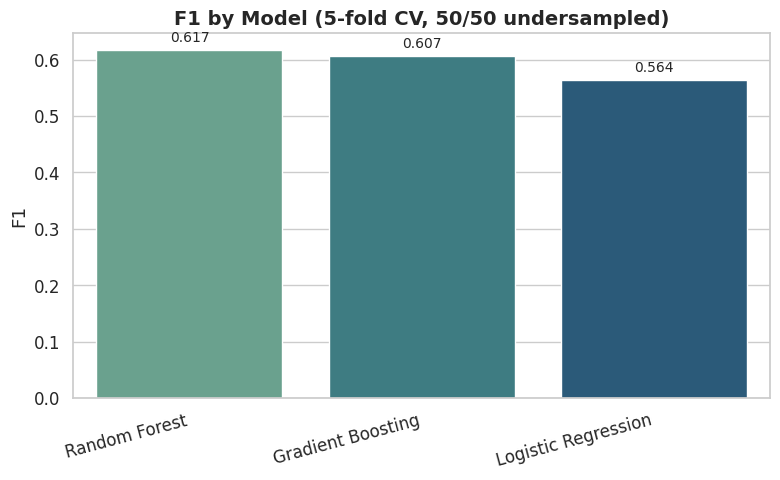

/tmp/ipython-input-1191781506.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


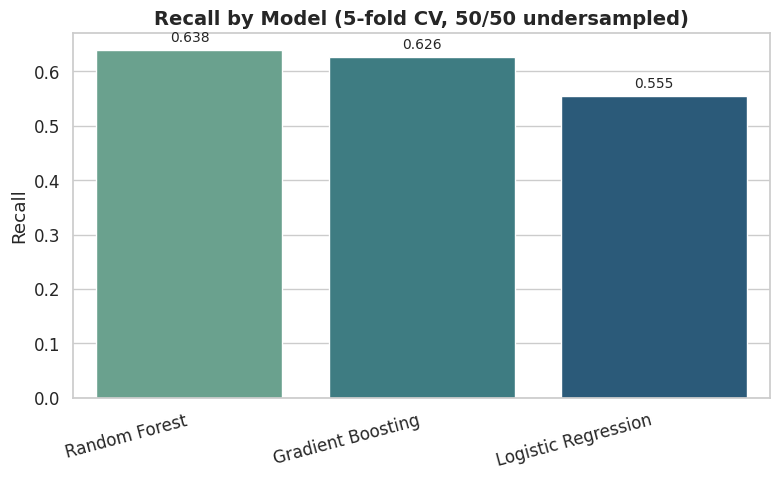

/tmp/ipython-input-1191781506.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


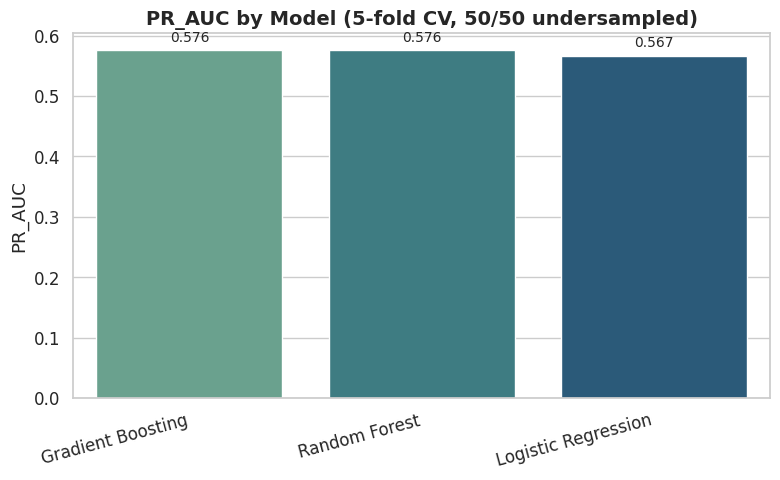

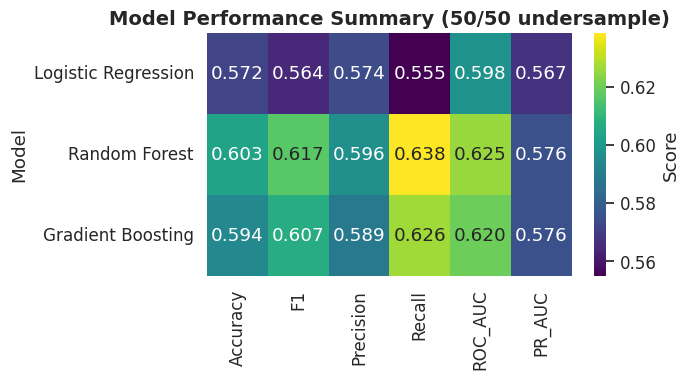

In [53]:
# We want to use these metrics to make a nice plot to display and later on compare models
# we chose a heatmap for this and also have bars in general to see
# Plots -  F1, Recall, PR_AUC
sns.set(style="whitegrid", font_scale=1.1)
metrics_to_plot = ["F1", "Recall", "PR_AUC"]

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    order = metrics_df.sort_values(metric, ascending=False)["Model"]

    ax = sns.barplot(
        data=metrics_df,
        x="Model",
        y=metric,
        order=order,
        palette="crest"
    )
    ax.set_title(f"{metric} by Model (5-fold CV, 50/50 undersampled)", fontsize=14, weight="bold")
    ax.set_xlabel("")
    ax.set_ylabel(metric)

    # annotate bars with numeric values
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.3f}",
                    (p.get_x() + p.get_width() / 2., h),
                    ha="center", va="bottom", fontsize=10,
                    xytext=(0, 4), textcoords="offset points")

    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    plt.show()

# heatmap of all metrics
plt.figure(figsize=(7, 4))
sns.heatmap(
    metrics_df.set_index("Model")[["Accuracy","F1","Precision","Recall","ROC_AUC","PR_AUC"]],
    annot=True, fmt=".3f", cmap="viridis", cbar_kws={"label": "Score"}
)
plt.title("Model Performance Summary (50/50 undersample)", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


##Faster Fine-tuning to try to improve PR-AUC for models

In [55]:
# import again for this chunk but we did not end up using RANDOMDIZED search CV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import uniform, randint

cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def make_pipeline(model):
    return Pipeline([
        ("preprocess", preprocessor),  # existing preprocessor
        ("model", model),
    ])

logreg_param_dist = {
    'model__C': uniform(0.01, 10),
    'model__max_iter': [1000, 1500],
    'model__solver': ['liblinear'],  # fast and supports l1/l2
}

rf_param_dist = {
    'model__n_estimators': randint(100, 300),
    'model__max_depth': randint(5, 20),
    'model__min_samples_leaf': randint(1, 4),
    'model__max_features': ['sqrt', 'log2'],
    'model__class_weight': ['balanced', None],  # we tried balanced class weights too
}

gb_param_dist = {
    'model__n_estimators': randint(100, 300),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__max_depth': randint(2, 5),
    'model__min_samples_leaf': randint(1, 4),
    'model__subsample': uniform(0.6, 0.4),
}

def quick_random_search(model_cls, param_dist, X, y, n_iter=10):
    pipe = make_pipeline(model_cls(random_state=42))
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='average_precision',  # maximize PR_AUC
        cv=cv_fast,
        n_jobs=-1,
        random_state=42,
        verbose=1,
    )
    search.fit(X, y)
    print(f"Best params for {model_cls.__name__}: {search.best_params_}")
    print(f"Best PR_AUC: {search.best_score_:.4f}")
    return search.best_estimator_

best_pipes = {}
best_pipes['Logistic Regression'] = quick_random_search(LogisticRegression, logreg_param_dist, X, y, n_iter=5)
best_pipes['Random Forest'] = quick_random_search(RandomForestClassifier, rf_param_dist, X, y, n_iter=5)
best_pipes['Gradient Boosting'] = quick_random_search(GradientBoostingClassifier, gb_param_dist, X, y, n_iter=5)

# Then evaluate final performance with existing 5-fold CV metrics code

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params for LogisticRegression: {'model__C': np.float64(0.5908361216819946), 'model__max_iter': 1500, 'model__solver': 'liblinear'}
Best PR_AUC: 0.5725
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params for RandomForestClassifier: {'model__class_weight': 'balanced', 'model__max_depth': 11, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__n_estimators': 187}
Best PR_AUC: 0.5787
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params for GradientBoostingClassifier: {'model__learning_rate': np.float64(0.0849080237694725), 'model__max_depth': 2, 'model__min_samples_leaf': 3, 'model__n_estimators': 206, 'model__subsample': np.float64(0.9118764001091078)}
Best PR_AUC: 0.5790


Evaluating final tuned model: Logistic Regression
Evaluating final tuned model: Random Forest
Evaluating final tuned model: Gradient Boosting

=== Final tuned model metrics (5-fold CV) ===
                 Model  Accuracy        F1  Precision    Recall   ROC_AUC  \
0  Logistic Regression  0.572792  0.567110   0.574755  0.559666  0.602043   
1        Random Forest  0.613962  0.630918   0.604372  0.659905  0.627692   
2    Gradient Boosting  0.605012  0.613769   0.600457  0.627685  0.628887   

     PR_AUC  
0  0.571404  
1  0.568844  
2  0.582650  


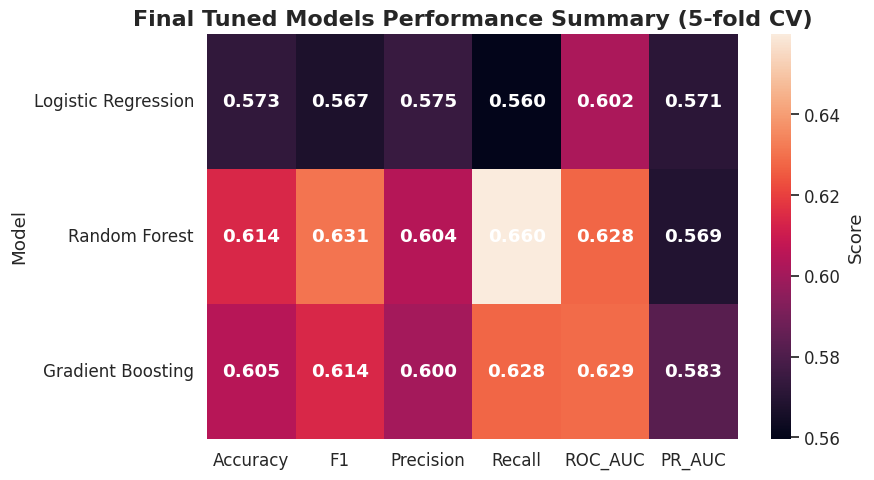

In [58]:
# Based on this we see that

# Assuming your evaluate_model function and metrics_df creation code already exist,
# simply replace the model list with your tuned best_pipes and rerun that block:

metrics_list = []
for name, pipe in best_pipes.items():
    print(f"Evaluating final tuned model: {name}")
    proba, preds, metrics = evaluate_model(pipe, X, y, cv=cv_final)  # use your existing evaluate_model
    metrics["Model"] = name
    metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df[["Model", "Accuracy", "F1", "Precision", "Recall", "ROC_AUC", "PR_AUC"]]

print("\n=== Final tuned model metrics (5-fold CV) ===")
print(metrics_df)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(9, 5))

cmap = sns.color_palette("rocket", as_cmap=True)

ax = sns.heatmap(
    metrics_df.set_index("Model"),
    annot=True,
    fmt=".3f",
    cmap=cmap,
    cbar_kws={"label": "Score"},
    linewidths=0,
    annot_kws={"weight": "bold", "color": "white"},
)

ax.set_title("Final Tuned Models Performance Summary (5-fold CV)", fontsize=16, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("Model")

plt.xticks(rotation=0, ha="center")
plt.yticks(rotation=0, ha="right", va="center")

plt.tight_layout()
plt.show()


# Run models on Original Imbalanced and not undersampled data to compare

Evaluating on original data: Logistic Regression
Evaluating on original data: Random Forest
Evaluating on original data: Gradient Boosting

=== Metrics on Original Imbalanced Data ===
                 Model  Accuracy        F1  Precision    Recall   ROC_AUC  \
0  Logistic Regression  0.982154  0.002326   0.045455  0.001193  0.613957   
1        Random Forest  0.938081  0.047969   0.032765  0.089499  0.634610   
2    Gradient Boosting  0.982570  0.000000   0.000000  0.000000  0.647045   

     PR_AUC  
0  0.026608  
1  0.026279  
2  0.028832  


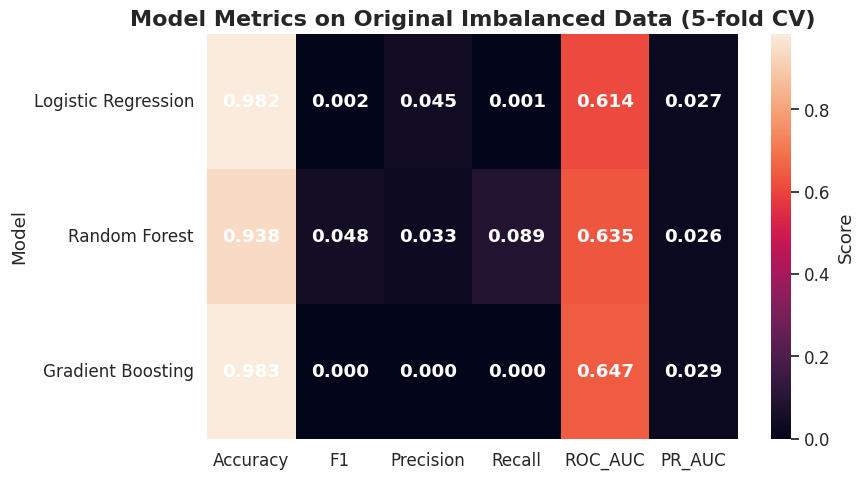

In [60]:
# reimports to be safe
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, average_precision_score
)

import pandas as pd

# redefining original imbalanced data
X_orig = cleaned_df[filtered_features].copy()
y_orig = cleaned_df["viral"].astype(int).values

cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_list = []

for name, pipe in best_pipes.items():  # tuned pipelines dict
    print(f"Evaluating on original data: {name}")
    proba = cross_val_predict(pipe, X_orig, y_orig, cv=cv_final, method="predict_proba", n_jobs=-1)[:, 1]
    preds = (proba >= 0.5).astype(int)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_orig, preds),
        "F1": f1_score(y_orig, preds, zero_division=0),
        "Precision": precision_score(y_orig, preds, zero_division=0),
        "Recall": recall_score(y_orig, preds, zero_division=0),
        "ROC_AUC": roc_auc_score(y_orig, proba),
        "PR_AUC": average_precision_score(y_orig, proba),
    }
    metrics_list.append(metrics)

metrics_orig_df = pd.DataFrame(metrics_list)

print("\n=== Metrics on Original Imbalanced Data ===")
print(metrics_orig_df)

# plot heatmap with divativities theme palette (pink/magenta hues)
plt.figure(figsize=(9, 5))
ax = sns.heatmap(
    metrics_orig_df.set_index("Model"),
    annot=True, fmt=".3f",
    cmap=sns.color_palette("rocket", as_cmap=True),
    cbar_kws={"label": "Score"},
    linewidths=0,
    annot_kws={"weight": "bold", "color": "white"},
)

ax.set_title("Model Metrics on Original Imbalanced Data (5-fold CV)", fontsize=16, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("Model")
plt.xticks(rotation=0, ha="center")
plt.yticks(rotation=0, ha="right", va="center")
plt.tight_layout()
plt.show()